In [1]:
!pip install xgboost lightgbm catboost scikit-learn -q

In [2]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import warnings

# Tắt các cảnh báo không cần thiết
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)


# Preprocessing and Splitting
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

# Evaluation
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

print("Tất cả thư viện đã được import thành công!")

Tất cả thư viện đã được import thành công!


In [3]:
RAW_DATA_PATH = '/kaggle/input/tabular-stroke-data/synthetic_multimodal.csv'
TARGET_COL = "stroke"
DROP_COLUMNS = ["id", "image_path"]
CATEGORICAL_FEATURES = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status", "hypertension", "heart_disease"]
NUMERICAL_FEATURES = ["age", "avg_glucose_level", "bmi"]
SEED = 42

In [4]:
print("--- Bắt đầu tải và làm sạch dữ liệu ---")
df = pd.read_csv(RAW_DATA_PATH)
df = df.drop(columns=DROP_COLUMNS, errors='ignore')

df['bmi'] = df['bmi'].replace('N/A', np.nan)
df['bmi'] = pd.to_numeric(df['bmi'])
df['bmi'].fillna(df['bmi'].median(), inplace=True)
df = df[df['gender'] != 'Other'].reset_index(drop=True)

print(f"Dữ liệu đã được làm sạch. Tổng số mẫu: {len(df)}")

--- Bắt đầu tải và làm sạch dữ liệu ---
Dữ liệu đã được làm sạch. Tổng số mẫu: 1800


In [5]:
for col in CATEGORICAL_FEATURES:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop(TARGET_COL, axis=1)
y = df[TARGET_COL]

In [6]:
# --- PIPELINE CHO CÁC MÔ HÌNH TRỪ CATBOOST ---
preprocessor_onehot = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), NUMERICAL_FEATURES),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), CATEGORICAL_FEATURES)
    ],
    remainder='passthrough'
)



In [7]:
param_grids = {
    'XGBoost': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 5],
        'classifier__learning_rate': [0.1],
    },
    'LightGBM': {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.1],
        'classifier__num_leaves': [20, 31],
    },
    'CatBoost': {
        'classifier__iterations': [200, 400],
        'classifier__depth': [4, 6],
        'classifier__learning_rate': [0.05],
    },
    'RandomForest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, None],
        'classifier__min_samples_split': [2, 5],
    },
    'LogisticRegression': {
        'classifier__C': [0.1, 1.0, 10],
        'classifier__solver': ['liblinear'],
    },
    'SVM' : {
        'classifier__C': [0.1, 1, 10],     
        'classifier__gamma': ['scale', 'auto'], 
        'classifier__kernel': ['rbf']          
    }
}

In [8]:
# --- CẤU HÌNH CROSS-VALIDATION ---
N_SPLITS = 10
REPEATS = 3

# Dictionary để lưu kết quả của tất cả các lần chạy
all_results = {name: {'labels': [], 'preds': [], 'best_params': []} for name in param_grids.keys()}  # ✅ Thêm best_params

# --- BẮT ĐẦU VÒNG LẶP LẶP ---
total_start_time = datetime.now()

for r in range(REPEATS):
    print(f"\n\n{'='*30} REPEAT {r+1}/{REPEATS} {'='*30}")
    # Sử dụng StratifiedKFold thay vì KFold để đảm bảo tỷ lệ class cân bằng
    kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED + r)
    
    for fold, (train_val_idx, test_idx) in enumerate(kf.split(X, y)):
        print(f"\n--- Fold {fold+1}/{N_SPLITS} ---")
        
        # 1. CHIA DỮ LIỆU
        X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
        y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]

        # 2. TÍNH TOÁN TRỌNG SỐ CHO FOLD HIỆN TẠI
        neg_count = (y_train_val == 0).sum()
        pos_count = (y_train_val == 1).sum()
        scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1.0
        print(f"Fold {fold+1} scale_pos_weight: {scale_pos_weight:.2f}")

        # 3. HUẤN LUYỆN VÀ ĐÁNH GIÁ TỪNG MÔ HÌNH
        for model_name, param_grid in param_grids.items():
            print(f"\nTraining {model_name}...")
            start_model_time = datetime.now()
            
            # === XỬ LÝ CATBOOST RIÊNG (không dùng Pipeline) ===
            if model_name == 'CatBoost':
                # Tìm chỉ số của categorical features trong DataFrame
                cat_feature_indices = [X_train_val.columns.get_loc(col) for col in CATEGORICAL_FEATURES]
                
                # CatBoost xử lý categorical features tự động
                model = ctb.CatBoostClassifier(
                    loss_function='Logloss', 
                    random_state=SEED, 
                    scale_pos_weight=scale_pos_weight, 
                    verbose=0,
                    cat_features=cat_feature_indices
                )
                
                # Chuẩn bị param_grid cho CatBoost (bỏ prefix 'classifier__')
                catboost_param_grid = {
                    'iterations': param_grid['classifier__iterations'],
                    'depth': param_grid['classifier__depth'],
                    'learning_rate': param_grid['classifier__learning_rate']
                }
                
                # GridSearchCV trực tiếp trên model
                grid_search = GridSearchCV(
                    model, 
                    catboost_param_grid,
                    cv=3, 
                    scoring=make_scorer(f1_score), 
                    n_jobs=-1
                )
                
                # ✅ FIT TRỰC TIẾP - CatBoost tự xử lý
                grid_search.fit(X_train_val, y_train_val)
                best_model = grid_search.best_estimator_
                y_pred_proba = best_model.predict_proba(X_test)[:, 1]
            
            # === XỬ LÝ CÁC MÔ HÌNH KHÁC (dùng Pipeline) ===
            else:
                # Tạo pipeline với preprocessor
                if model_name == 'XGBoost':
                    classifier = xgb.XGBClassifier(
                        objective='binary:logistic', 
                        eval_metric='logloss', 
                        use_label_encoder=False, 
                        random_state=SEED, 
                        scale_pos_weight=scale_pos_weight
                    )
                elif model_name == 'LightGBM':
                    classifier = lgb.LGBMClassifier(
                        objective='binary', 
                        random_state=SEED, 
                        scale_pos_weight=scale_pos_weight,
                        verbose=-1
                    )
                elif model_name == 'RandomForest':
                    classifier = RandomForestClassifier(
                        random_state=SEED, 
                        class_weight='balanced'
                    )
                elif model_name == 'LogisticRegression':
                    classifier = LogisticRegression(
                        random_state=SEED, 
                        class_weight='balanced',
                        max_iter=1000
                    )
                elif model_name == 'SVM':
                    classifier = SVC(
                        random_state=SEED, 
                        class_weight='balanced', 
                        probability=True
                    )
                
                # Tạo pipeline
                pipeline = Pipeline(steps=[
                    ('preprocessor', preprocessor_onehot),
                    ('classifier', classifier)
                ])
                
                # GridSearchCV với pipeline
                grid_search = GridSearchCV(
                    pipeline, 
                    param_grid, 
                    cv=3, 
                    scoring=make_scorer(f1_score), 
                    n_jobs=-1
                )
                
                # ✅ FIT PIPELINE - Preprocessing sẽ được thực hiện đúng trong mỗi fold của CV
                grid_search.fit(X_train_val, y_train_val)
                best_model = grid_search.best_estimator_
                y_pred_proba = best_model.predict_proba(X_test)[:, 1]

            # ✅ Lưu kết quả VÀ best_params
            all_results[model_name]['labels'].append(y_test.values)
            all_results[model_name]['preds'].append(y_pred_proba)
            all_results[model_name]['best_params'].append(grid_search.best_params_)  # ✅ Lưu best_params
            
            print(f"Finished {model_name} in {datetime.now() - start_model_time}. Best F1: {grid_search.best_score_:.4f}")

print(f"\n\nTổng thời gian thực thi: {datetime.now() - total_start_time}")



============================== REPEAT 1/3 ==============================

--- Fold 1/10 ---
Fold 1 scale_pos_weight: 6.20

Training XGBoost...
Finished XGBoost in 0:00:02.217864. Best F1: 0.4555

Training LightGBM...
Finished LightGBM in 0:00:04.737385. Best F1: 0.4245

Training CatBoost...
Finished CatBoost in 0:00:09.195813. Best F1: 0.4647

Training RandomForest...
Finished RandomForest in 0:00:03.356274. Best F1: 0.3797

Training LogisticRegression...
Finished LogisticRegression in 0:00:00.117571. Best F1: 0.4630

Training SVM...
Finished SVM in 0:00:01.863092. Best F1: 0.4465

--- Fold 2/10 ---
Fold 2 scale_pos_weight: 6.23

Training XGBoost...
Finished XGBoost in 0:00:00.454573. Best F1: 0.4667

Training LightGBM...
Finished LightGBM in 0:00:01.509068. Best F1: 0.4207

Training CatBoost...
Finished CatBoost in 0:00:08.449470. Best F1: 0.4698

Training RandomForest...
Finished RandomForest in 0:00:03.299089. Best F1: 0.3516

Training LogisticRegression...
Finished LogisticRegres

In [9]:
def print_evaluation_metrics(y_true, y_pred, y_pred_proba, model_name):
    """
    Tính toán và in ra các chỉ số đánh giá cho một mô hình.
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0) # Thêm zero_division để tránh lỗi
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    print(f"--- Kết quả đánh giá cho mô hình: {model_name} ---")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC AUC:   {roc_auc:.4f}")
    
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1, 'roc_auc': roc_auc}


In [10]:
def plot_combined_roc_curve(results, title='Đường cong ROC so sánh các mô hình'):
    """
    Vẽ đường cong ROC của nhiều mô hình trên cùng một biểu đồ.
    """
    plt.figure(figsize=(12, 10))
    for model_name, data in results.items():
        # Đảm bảo y_true và y_pred_proba có dữ liệu
        if len(data['y_true']) > 0 and len(data['y_pred_proba']) > 0:
            fpr, tpr, _ = roc_curve(data['y_true'], data['y_pred_proba'])
            roc_auc_val = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc_val:.4f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tỷ lệ Dương tính Giả (False Positive Rate)')
    plt.ylabel('Tỷ lệ Dương tính Thật (True Positive Rate)')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [11]:
def plot_single_confusion_matrix(y_true, y_pred, model_name):
    """
    Vẽ ma trận nhầm lẫn cho một mô hình.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Dự đoán 0 (Không đột quỵ)', 'Dự đoán 1 (Có đột quỵ)'],
                yticklabels=['Thực tế 0 (Không đột quỵ)', 'Thực tế 1 (Có đột quỵ)'])
    plt.title(f'Ma trận nhầm lẫn cho: {model_name}')
    plt.ylabel('Nhãn thực tế')
    plt.xlabel('Nhãn dự đoán')
    plt.show()



KẾT QUẢ SO SÁNH CUỐI CÙNG (TRUNG BÌNH TRÊN 3 REPEATS x 10 FOLDS)
                    accuracy  precision  recall  f1_score  roc_auc
XGBoost               0.7672     0.3404  0.7282    0.4640   0.8271
LightGBM              0.8152     0.3864  0.5716    0.4611   0.8271
CatBoost              0.7576     0.3345  0.7604    0.4646   0.8318
RandomForest          0.8261     0.3919  0.4659    0.4257   0.8290
LogisticRegression    0.7467     0.3285  0.7965    0.4652   0.8403
SVM                   0.8656     0.5854  0.0964    0.1655   0.8336

--- Đang vẽ đường cong ROC so sánh ---


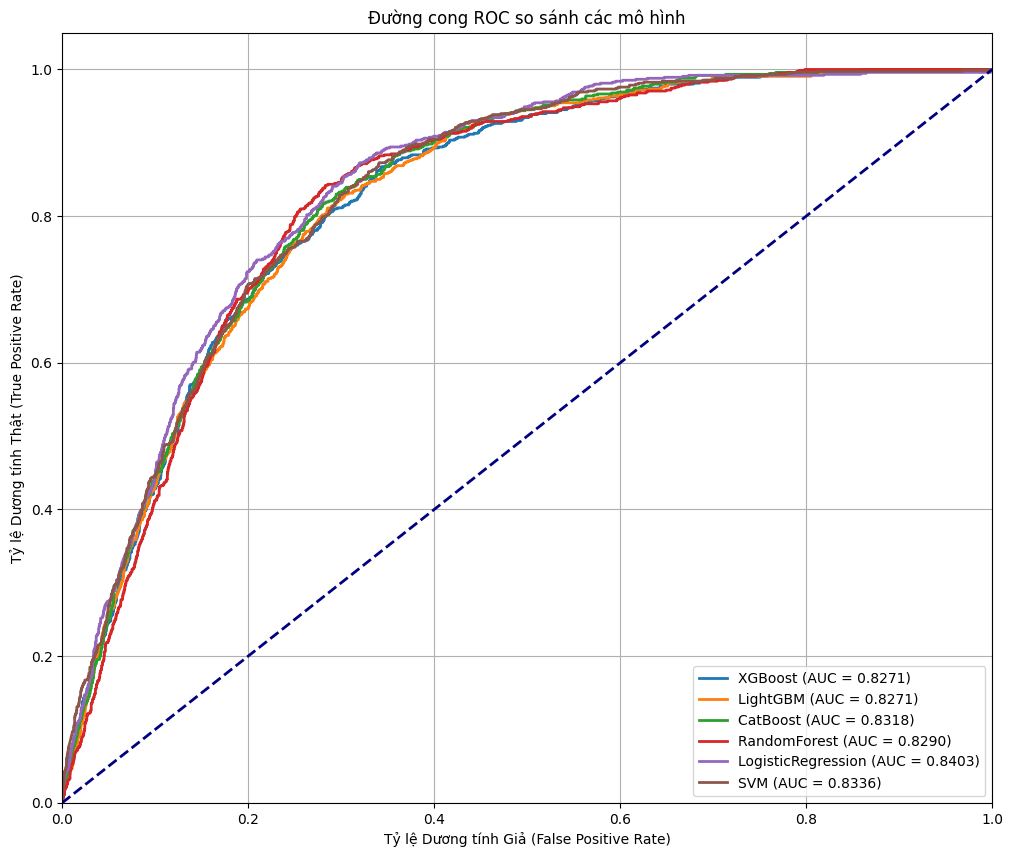


--- Đang vẽ ma trận nhầm lẫn cho tất cả các mô hình ---


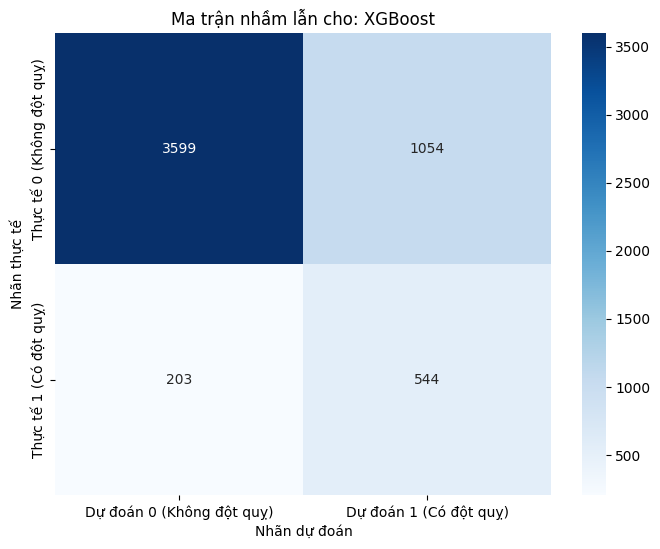

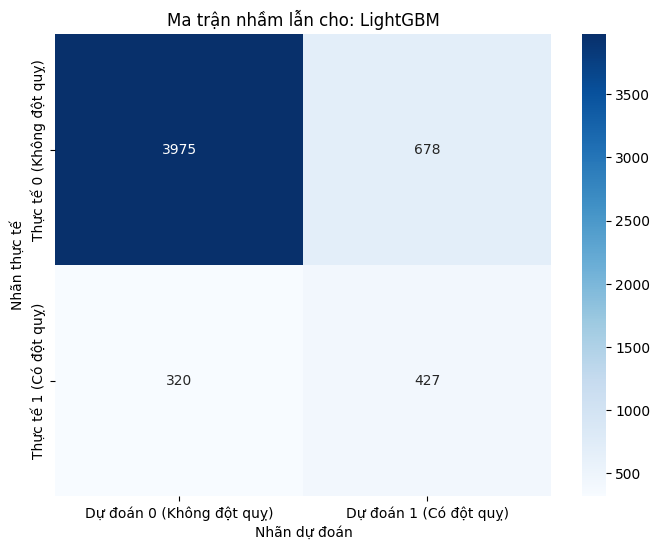

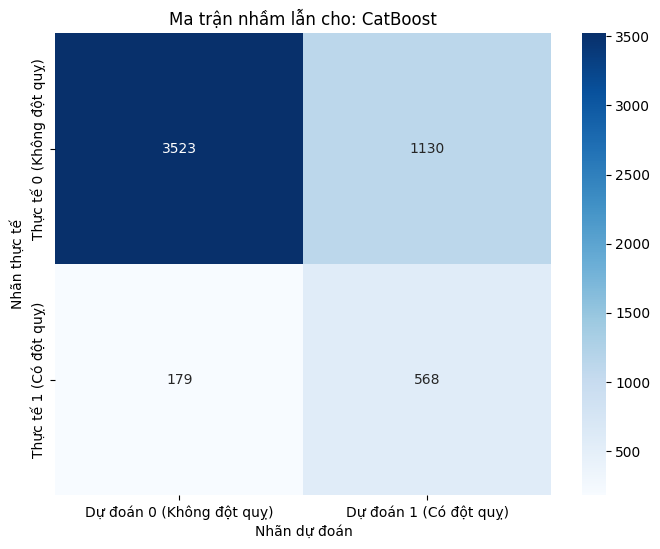

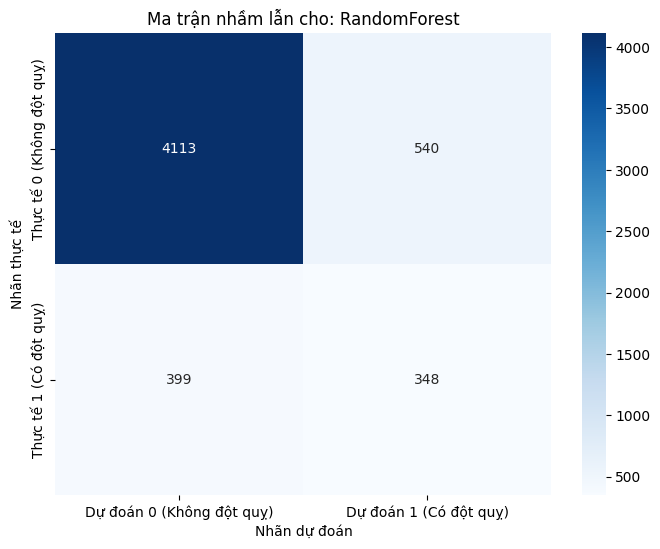

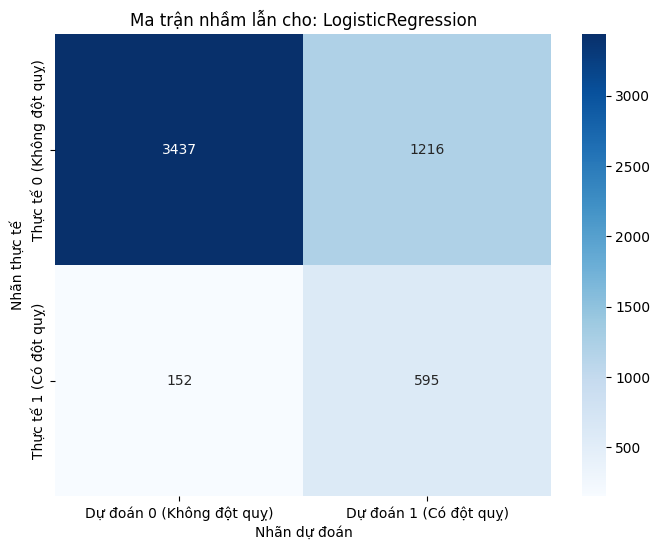

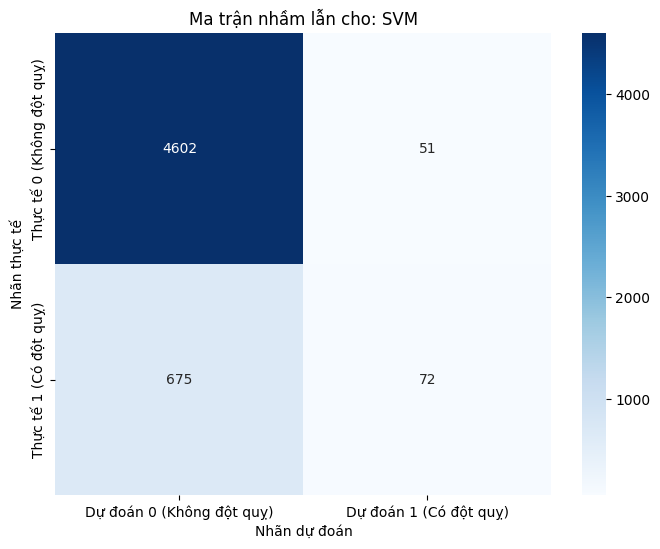

In [12]:
print("\n" + "="*80)
print("KẾT QUẢ SO SÁNH CUỐI CÙNG (TRUNG BÌNH TRÊN 3 REPEATS x 10 FOLDS)")
print("="*80)

final_metrics_summary = {}
final_predictions = {}

for model_name, data in all_results.items():
    # Gộp kết quả từ tất cả các lần chạy
    y_true_all = np.concatenate(data['labels'])
    y_pred_proba_all = np.concatenate(data['preds'])
    y_pred_all = (y_pred_proba_all >= 0.5).astype(int)

    # Lưu predictions để vẽ confusion matrix
    final_predictions[model_name] = {
        'y_true': y_true_all,
        'y_pred': y_pred_all,
        'y_pred_proba': y_pred_proba_all
    }

    # Tính toán các chỉ số cuối cùng
    metrics = {
        'accuracy': accuracy_score(y_true_all, y_pred_all),
        'precision': precision_score(y_true_all, y_pred_all, zero_division=0),
        'recall': recall_score(y_true_all, y_pred_all),
        'f1_score': f1_score(y_true_all, y_pred_all),
        'roc_auc': roc_auc_score(y_true_all, y_pred_proba_all)
    }
    final_metrics_summary[model_name] = metrics
    
# In bảng kết quả
results_df = pd.DataFrame(final_metrics_summary).T
print(results_df.round(4))

# Trực quan hóa ROC AUC của tất cả các mô hình
print("\n--- Đang vẽ đường cong ROC so sánh ---")
plot_combined_roc_curve(
    {name: {'y_true': np.concatenate(data['labels']), 'y_pred_proba': np.concatenate(data['preds'])} for name, data in all_results.items()}
)

# Vẽ ma trận nhầm lẫn cho tất cả các mô hình
print("\n--- Đang vẽ ma trận nhầm lẫn cho tất cả các mô hình ---")
for model_name, preds in final_predictions.items():
    plot_single_confusion_matrix(preds['y_true'], preds['y_pred'], model_name)

In [13]:
# --- LƯU KẾT QUẢ METRICS RA FILE CSV ---
output_dir = '/kaggle/working/'
os.makedirs(output_dir, exist_ok=True)

# Lưu bảng metrics
metrics_file = os.path.join(output_dir, 'model_comparison_metrics.csv')
results_df.to_csv(metrics_file, index=True)
print(f"✅ Đã lưu bảng metrics vào: {metrics_file}")
print(f"\nNội dung file:")
print(results_df.round(4))

✅ Đã lưu bảng metrics vào: /kaggle/working/model_comparison_metrics.csv

Nội dung file:
                    accuracy  precision  recall  f1_score  roc_auc
XGBoost               0.7672     0.3404  0.7282    0.4640   0.8271
LightGBM              0.8152     0.3864  0.5716    0.4611   0.8271
CatBoost              0.7576     0.3345  0.7604    0.4646   0.8318
RandomForest          0.8261     0.3919  0.4659    0.4257   0.8290
LogisticRegression    0.7467     0.3285  0.7965    0.4652   0.8403
SVM                   0.8656     0.5854  0.0964    0.1655   0.8336


In [14]:
# --- PHÂN TÍCH SIÊU THAM SỐ TỐT NHẤT ---
print("\n" + "="*80)
print("SIÊU THAM SỐ PHỔ BIẾN NHẤT (xuất hiện nhiều nhất qua các folds)")
print("="*80)

from collections import Counter

best_params_summary_df = []

for model_name, data in all_results.items():
    print(f"\n🔹 {model_name}:")
    
    params_list = data['best_params']
    
    # Đếm tần suất của mỗi tổ hợp tham số
    params_counter = Counter([str(sorted(p.items())) for p in params_list])
    most_common_params_str = params_counter.most_common(1)[0][0]
    frequency = params_counter.most_common(1)[0][1]
    total_runs = len(params_list)
    
    # Chuyển đổi lại thành dict
    most_common_params = dict(eval(most_common_params_str))
    
    print(f"   Tần suất: {frequency}/{total_runs} runs ({frequency/total_runs*100:.1f}%)")
    for param, value in most_common_params.items():
        print(f"   {param}: {value}")
    
    # Phân tích chi tiết từng tham số
    print(f"   \n   📊 Phân bố các giá trị:")
    
    # Tạo dict để đếm từng tham số riêng lẻ
    param_values = {}
    for params in params_list:
        for key, val in params.items():
            if key not in param_values:
                param_values[key] = []
            param_values[key].append(val)
    
    # In phân bố của từng tham số
    for param_name, values in param_values.items():
        value_counts = Counter(values)
        print(f"      • {param_name}:")
        for val, count in value_counts.most_common():
            print(f"         - {val}: {count}/{total_runs} lần ({count/total_runs*100:.1f}%)")
    
    # Lưu vào dataframe
    row = {
        'Model': model_name, 
        'Frequency': f"{frequency}/{total_runs}",
        'Percentage': f"{frequency/total_runs*100:.1f}%"
    }
    row.update(most_common_params)
    best_params_summary_df.append(row)

# Tạo DataFrame và lưu
best_params_df = pd.DataFrame(best_params_summary_df)
output_dir = '/kaggle/working/'
os.makedirs(output_dir, exist_ok=True)

best_params_file = os.path.join(output_dir, 'best_hyperparameters.csv')
best_params_df.to_csv(best_params_file, index=False)
print(f"\n✅ Đã lưu siêu tham số tốt nhất vào: {best_params_file}")

# Hiển thị bảng tổng hợp
print("\n" + "="*80)
print("BẢNG TỔNG HỢP SIÊU THAM SỐ")
print("="*80)
print(best_params_df.to_string(index=False))


SIÊU THAM SỐ PHỔ BIẾN NHẤT (xuất hiện nhiều nhất qua các folds)

🔹 XGBoost:
   Tần suất: 21/30 runs (70.0%)
   classifier__learning_rate: 0.1
   classifier__max_depth: 3
   classifier__n_estimators: 100
   
   📊 Phân bố các giá trị:
      • classifier__learning_rate:
         - 0.1: 30/30 lần (100.0%)
      • classifier__max_depth:
         - 3: 28/30 lần (93.3%)
         - 5: 2/30 lần (6.7%)
      • classifier__n_estimators:
         - 100: 23/30 lần (76.7%)
         - 200: 7/30 lần (23.3%)

🔹 LightGBM:
   Tần suất: 29/30 runs (96.7%)
   classifier__learning_rate: 0.1
   classifier__n_estimators: 100
   classifier__num_leaves: 20
   
   📊 Phân bố các giá trị:
      • classifier__learning_rate:
         - 0.1: 30/30 lần (100.0%)
      • classifier__n_estimators:
         - 100: 30/30 lần (100.0%)
      • classifier__num_leaves:
         - 20: 29/30 lần (96.7%)
         - 31: 1/30 lần (3.3%)

🔹 CatBoost:
   Tần suất: 17/30 runs (56.7%)
   depth: 4
   iterations: 200
   learning_rate: 0

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [15]:
# --- LƯU CHI TIẾT TẤT CẢ SIÊU THAM SỐ TỪ MỖI FOLD ---
print("\n" + "="*80)
print("LƯU CHI TIẾT SIÊU THAM SỐ CỦA TẤT CẢ CÁC FOLDS")
print("="*80)

all_params_details = []

for model_name, data in all_results.items():
    params_list = data['best_params']
    
    for idx, params in enumerate(params_list):
        repeat_num = idx // N_SPLITS + 1
        fold_num = idx % N_SPLITS + 1
        
        row = {
            'Model': model_name,
            'Repeat': repeat_num,
            'Fold': fold_num,
            'Run': idx + 1
        }
        row.update(params)
        all_params_details.append(row)

all_params_df = pd.DataFrame(all_params_details)
all_params_file = os.path.join(output_dir, 'all_hyperparameters_details.csv')
all_params_df.to_csv(all_params_file, index=False)

print(f"✅ Đã lưu chi tiết tất cả siêu tham số vào: {all_params_file}")
print(f"\nTổng số dòng: {len(all_params_df)}")
print(f"Preview:")
print(all_params_df.head(10))


LƯU CHI TIẾT SIÊU THAM SỐ CỦA TẤT CẢ CÁC FOLDS
✅ Đã lưu chi tiết tất cả siêu tham số vào: /kaggle/working/all_hyperparameters_details.csv

Tổng số dòng: 180
Preview:
     Model  Repeat  Fold  Run  classifier__learning_rate  \
0  XGBoost       1     1    1                        0.1   
1  XGBoost       1     2    2                        0.1   
2  XGBoost       1     3    3                        0.1   
3  XGBoost       1     4    4                        0.1   
4  XGBoost       1     5    5                        0.1   
5  XGBoost       1     6    6                        0.1   
6  XGBoost       1     7    7                        0.1   
7  XGBoost       1     8    8                        0.1   
8  XGBoost       1     9    9                        0.1   
9  XGBoost       1    10   10                        0.1   

   classifier__max_depth  classifier__n_estimators  classifier__num_leaves  \
0                    3.0                     100.0                     NaN   
1               

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
